<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [149]:
import pandas as pd 
stock='T'
df=pd.read_csv('gdrive/My Drive/SS_AITrader/'+stock+'/df_'+stock+'_20drtn_features.csv')

In [150]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,56.186841,37.974518,43.423366,38.837279,-52.027007,-64.735944,-64.735944,-69.196421,54.738104,34.844928,44.694770,47.593574,-1.212977,-0.114093,-2.614012,1.595588,-3.791212,-0.306026,-0.291145,-0.282764,-0.174326,-0.725742,-0.725742,-0.725742,-0.725742,38.816388,7.812509,-28.925778,-60.906424,-63.301513,-64.211361,0.240000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263152,-0.132251,0.355017,-0.017786,0.349237,-0.017350,27.549999,2.949999,4.019999,-2.448812e+06,-2.448812e+06,-2.448812e+06,-2.448812e+06,0.239754,0.082016,0.170259,0.125603,-0.030990,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,55.612095,30.320251,44.581166,42.166444,-52.364917,-61.058654,-64.906338,-69.345263,42.733206,34.988828,40.810531,48.817122,-0.028561,0.401490,0.516786,0.085760,-5.378383,-0.294623,-0.288734,-0.282348,-0.177366,-0.706086,-0.706086,-0.706086,-0.706086,-0.000669,-50.902506,-30.980872,-61.866693,-62.759947,-64.921475,0.450549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252840,-0.155738,0.348563,-0.018180,0.349260,-0.023251,27.490000,-0.059999,0.949999,-1.716356e+06,-1.716356e+06,-1.716356e+06,-1.716356e+06,0.109111,0.102903,0.136474,0.101350,0.194076,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,46.055460,31.843850,40.606090,41.836413,-64.526959,-67.863885,-71.039164,-72.222205,33.734927,35.142928,41.201732,46.612140,-1.028269,-2.256697,-1.169423,-2.394362,-4.729165,-0.287935,-0.287119,-0.282138,-0.180354,-0.711358,-0.711358,-0.711358,-0.711358,-81.290802,-130.283279,-65.361043,-75.022605,-63.376726,-66.910760,0.393942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243336,-0.169592,0.345653,-0.023264,0.348232,-0.023678,29.379999,1.889999,3.099998,-3.840481e+06,-3.840481e+06,-3.840481e+06,-3.840481e+06,0.007691,0.070538,0.141123,0.082206,-0.106213,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,56.544507,41.836021,49.242310,44.106154,-15.878404,-13.019422,-46.507667,-46.779651,35.238810,42.928215,41.703835,48.890248,4.155840,3.055396,3.498713,1.461907,-2.115538,-0.258749,-0.277949,-0.278558,-0.182840,-0.592509,-0.592509,-0.592509,-0.592509,140.096558,171.897978,152.618719,-6.866121,-58.808283,-63.640160,0.890756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328945,0.001296,0.375472,0.006547,0.358271,-0.013064,26.360001,-3.019999,0.840000,1.246150e+07,1.246150e+07,1.246150e+07,1.246150e+07,0.035271,0.208474,0.146847,0.109933,0.392836,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,47.360138,46.552675,44.199616,44.692949,-41.891908,-41.891908,-59.625224,-59.830511,35.374291,53.213705,37.849852,47.147338,-2.133556,0.885465,-0.366717,0.340906,-5.838440,-0.230940,-0.267614,-0.274089,-0.185081,-0.554067,-0.554067,-0.554067,-0.554067,63.398685,99.983340,104.899467,-16.994429,-54.170063,-60.573817,0.111112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344374,0.092796,0.375774,0.021809,0.360955,-0.011487,27.219999,0.859999,2.619999,1.836663e+06,1.836663e+06,1.836663e+06,1.836663e+06,0.032906,0.106237,0.102014,0.095143,-0.194399,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [151]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [152]:
from_date='2010-01-01'
to_date='2020-01-01'

In [153]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [154]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,78.199837,60.307705,60.593850,69.086997,-21.323477,-17.901185,-17.901185,-9.698964,92.145634,74.033672,69.836297,72.876396,-0.489851,0.423732,0.388283,4.099564,3.043479,0.200288,0.196276,0.174620,0.089900,0.381642,0.381642,0.381642,0.381642,86.917558,94.604234,103.631841,132.598628,50.185353,55.658976,0.236843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138203,-0.003671,0.149359,0.019918,0.140493,-0.008884,19.350000,-0.690001,-0.580000,1.544542e+06,1.544542e+06,1.544542e+06,1.544542e+06,0.150770,-0.106969,-0.098062,0.028075,0.209287,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,53.361045,44.080281,49.669355,60.238858,-94.915139,-69.135782,-69.135782,-39.716278,75.866613,64.839894,62.726187,69.459963,-2.918424,-1.498395,-2.575863,0.254175,-1.287089,0.184318,0.191420,0.174146,0.092069,0.313192,0.313192,0.313192,0.313192,-141.316136,-128.384366,-40.557656,-22.373006,45.731804,51.862741,0.125002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213813,0.071890,0.178215,0.049513,0.161177,0.024281,19.160000,-0.190001,-0.850000,-9.454477e+06,-9.454477e+06,-9.454477e+06,-9.454477e+06,0.004862,-0.140186,-0.153317,-0.007226,0.075497,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,45.386594,40.611429,43.145499,58.167779,-88.819966,-88.271682,-88.271682,-51.624551,62.293190,62.819615,61.788351,66.352212,-1.122787,-4.478659,-3.601697,-2.150539,-1.122787,0.150756,0.179828,0.170333,0.093736,0.231264,0.231264,0.231264,0.231264,-113.253538,-181.173363,-98.343749,-101.437679,41.285837,47.288429,0.315787,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208003,0.101344,0.176802,0.049871,0.160079,0.023691,19.059999,-0.100000,-0.900000,-9.775031e+06,-9.775031e+06,-9.775031e+06,-9.775031e+06,-0.133983,-0.136218,-0.146908,-0.043028,-0.113322,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,35.329113,43.328393,44.623245,54.645295,-88.108045,-88.108045,-88.108045,-58.844725,52.922218,62.854167,61.275912,63.775423,-0.732597,-4.711674,-3.317875,-3.352356,-1.669082,0.105339,0.162479,0.163372,0.094861,0.148487,0.148487,0.148487,0.148487,-91.781325,-160.787108,-125.299786,-147.341868,36.149653,41.993620,0.431375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205399,0.082947,0.178419,0.045317,0.161420,0.024313,18.129999,-0.930000,-3.550001,-8.358903e+06,-8.358903e+06,-8.358903e+06,-8.358903e+06,-0.202915,-0.091769,-0.165222,-0.046100,-0.177585,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,30.526696,42.828344,43.930634,53.684204,-93.617075,-93.617075,-93.617075,-63.537904,46.735809,63.029340,56.564848,61.482129,-0.479709,-2.318005,-5.633312,-4.021356,-2.845825,0.053998,0.140812,0.153717,0.095444,0.071569,0.071569,0.071569,0.071569,-78.310920,-122.433722,-134.796281,-157.574477,31.025912,36.957036,0.324322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203168,0.074128,0.176335,0.028883,0.161898,0.018564,17.549999,-0.580000,-2.490002,-6.690230e+06,-6.690230e+06,-6.690230e+06,-6.690230e+06,-0.240312,-0.091079,-0.169832,-0.063606,-0.066666,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [155]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,79.572796,76.271195,72.926549,55.701035,-7.638674,-4.680718,-4.417546,-16.666647,75.359814,71.312048,59.788998,56.094397,0.565120,1.688316,2.326198,2.486913,4.122349,0.073568,0.009702,0.018307,0.109133,0.190007,0.190007,0.190007,0.190007,133.956382,146.112206,158.120198,126.871505,-0.682380,1.885369,0.702711,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.068524,-0.016764,0.096922,-0.105806,0.188411,-0.016270,12.51,0.010000,-0.120000,5.935078e+06,5.935078e+06,5.935078e+06,5.935078e+06,0.148840,0.141947,0.104063,0.145031,0.928918,0.389,0.014,0.093,0.290001,0.540001,0.0
2891,2019-12-23,75.048399,81.710503,68.441239,59.712830,-22.360278,-14.285736,-13.533858,-19.090946,83.477882,77.648047,60.532922,58.682057,-0.204347,0.851828,1.243844,2.707673,3.496688,0.095381,0.021894,0.022952,0.107244,0.220590,0.220590,0.220590,0.220590,96.388268,127.467330,148.992357,139.921823,4.341705,6.682313,0.076920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063340,-0.024124,0.097676,-0.100572,0.188618,-0.012470,12.61,0.099999,0.469999,3.179640e+06,3.179640e+06,3.179640e+06,3.179640e+06,0.126030,0.096967,0.075719,0.129299,-0.397542,0.415,0.026,0.048,-0.029999,0.610001,0.0
2892,2019-12-27,79.657863,75.971478,75.726835,55.992925,-12.837749,-11.801152,-7.539627,-13.939369,87.166086,79.458150,71.285852,57.384520,0.204295,0.435122,0.796305,2.320739,4.195438,0.137529,0.054928,0.038341,0.102613,0.278141,0.278141,0.278141,0.278141,122.023980,99.129219,112.899483,132.217258,14.812800,15.318633,0.250006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068927,0.002093,0.081564,-0.020103,0.153405,-0.045615,13.43,0.780001,0.850000,2.092681e+06,2.092681e+06,2.092681e+06,2.092681e+06,0.126467,0.000965,0.033949,0.169687,-0.221380,0.356,-0.014,-0.019,-0.669998,-0.490005,0.0
2893,2019-12-30,68.026365,67.977851,69.394722,54.205846,-36.792348,-24.223555,-15.476163,-20.000000,89.475358,74.253174,71.255577,58.501005,-0.509686,0.205344,-0.280972,2.038690,4.440877,0.143537,0.063909,0.043411,0.101358,0.275983,0.275983,0.275983,0.275983,-26.786112,47.924153,72.558444,101.508099,16.448640,16.357114,0.200005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075219,0.006695,0.078308,-0.018614,0.153036,-0.035374,14.82,1.389999,2.320000,2.173893e+05,2.173893e+05,2.173893e+05,2.173893e+05,0.000933,0.017168,0.046884,0.127490,0.144854,0.405,0.049,0.016,-0.180000,-0.680000,0.0
2894,2019-12-31,73.100839,68.841424,75.930015,53.055649,-35.714147,-21.739027,-13.888826,-18.787851,81.149112,74.240279,71.787670,56.025378,0.102461,-0.204285,0.025601,1.269763,4.715976,0.145444,0.071381,0.048109,0.100196,0.274338,0.274338,0.274338,0.274338,-72.803325,10.312305,51.163113,83.509535,18.258366,17.467046,0.880005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065625,0.002286,0.077167,-0.020508,0.150138,-0.038480,13.78,-1.040000,1.270000,4.144857e+05,4.144857e+05,4.144857e+05,4.144857e+05,0.007515,0.114123,0.093050,0.127179,0.144380,0.414,0.009,-0.001,-0.349998,-1.320000,0.0


In [156]:
df.drop(['timestamp'], inplace=True, axis=1)

In [157]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [158]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,67.111925,60.228740,54.140565,47.042213,-3.658617,-3.658617,-4.242407,-38.345836,41.902625,38.169631,34.338085,47.388792,2.420346,2.608958,4.796240,2.671987,2.671987,-0.085796,-0.132717,-0.142203,-0.071352,-0.160597,-0.160597,-0.160597,-0.160597,166.666667,245.454852,202.560304,165.263219,-26.706370,-31.772015,0.884613,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.177395,0.065704,0.154207,-0.011409,0.208940,0.015044,19.540001,-1.400000,-8.089998,9.268437e+06,9.268437e+06,9.268437e+06,9.268437e+06,0.181559,0.125958,0.100807,0.103202,-0.022073,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,83.849857,73.238820,53.027319,56.169475,-22.711911,-22.711911,-22.112258,-22.112258,65.518027,45.114118,40.298185,55.466362,0.683446,2.498416,4.245737,6.157875,0.965736,0.039973,-0.036106,-0.012529,0.034714,0.167236,0.167236,0.167236,0.167236,81.014220,117.752183,162.266066,127.702596,-16.581916,-12.234172,0.581818,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.129351,-0.005170,0.202512,0.009455,0.180772,-0.002462,14.950000,-1.360000,-3.110000,9.226046e+06,9.226046e+06,9.226046e+06,9.226046e+06,0.102895,0.035953,-0.058125,0.072621,-0.563868,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,61.754393,65.583252,58.699793,55.632313,-4.054019,-4.054019,-2.666643,-2.390419,56.822528,64.213103,60.221783,57.088719,0.916188,4.681450,2.094063,1.954061,4.277697,0.096063,0.070253,0.025339,-0.065408,0.177205,0.177205,0.177205,0.177205,102.430559,156.313423,197.113047,174.342215,22.953345,21.448823,0.877552,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.188881,0.022650,0.176476,0.020606,0.181594,-0.010753,24.530001,-0.929998,-6.789999,7.785383e+06,7.785383e+06,7.785383e+06,7.785383e+06,0.118774,0.157388,0.194090,0.162603,-0.355363,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,35.323341,51.121718,70.452852,59.848895,-76.344168,-79.816580,-33.590764,-23.324422,29.983425,44.841426,58.884301,52.036278,-0.593864,-1.696576,-0.165676,-1.115852,7.071783,0.246398,0.270431,0.209879,0.053590,0.414728,0.414728,0.414728,0.414728,-100.939367,-103.996554,-118.628187,28.790579,77.654343,76.725388,0.372880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114559,0.033603,0.162988,0.005511,0.161710,0.000550,15.070000,-0.760000,-1.850000,-2.330310e+06,-2.330310e+06,-2.330310e+06,-2.330310e+06,0.117090,-0.041264,0.073090,0.006547,0.314301,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,31.381581,34.808976,46.142455,56.447131,-59.633159,-67.883287,-76.216271,-34.901011,28.646005,29.436835,44.720864,50.648947,-0.216514,0.847915,-0.054216,-1.390747,-1.496130,0.018400,0.121209,0.154020,0.174765,0.154452,0.154452,0.154452,0.154452,100.238472,-12.385595,-49.264472,-17.325007,30.427285,32.157395,0.499992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087082,0.017536,0.090595,-0.093660,0.164815,0.000974,16.350000,1.170000,2.330000,5.181839e+05,5.181839e+05,5.181839e+05,5.181839e+05,-0.067352,-0.014686,-0.092120,0.131415,-0.051888,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [159]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [160]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [161]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [162]:
get_sample_weights(train_labels)

real class weights are [1.11617312 0.90573013] [0 1]
value_counts (array([0, 1]), array([ 878, 1082]))


1856    0.905730
2747    0.905730
898     1.116173
765     0.905730
1100    0.905730
          ...   
2051    0.905730
1301    0.905730
2192    0.905730
1640    1.116173
2882    0.905730
Name: labels, Length: 1960, dtype: float64

In [163]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.11617312 0.90573013] [0 1]
value_counts (array([0, 1]), array([ 878, 1082]))


In [164]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [165]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [166]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_10',
 'rsi_15',
 'wr_10',
 'wr_15',
 'wr_20',
 'wr_40',
 'mfi_10',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_3',
 'roc_5',
 'roc_10',
 'cci_10',
 'cci_15',
 'cci_25',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'vix_level',
 'curve')

In [167]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('mfi_10',
 'mfi_20',
 'mfi_40',
 'roc_5',
 'roc_20',
 'trix_10',
 'trix_15',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_5',
 'kst_20',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'volume_delta',
 'curve',
 'dollarix_5d_change')

In [168]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,mfi_10,mfi_20,mfi_40,roc_5,roc_20,trix_10,trix_15,macd10,macd15,macd20,macd40,cci_5,kst_20,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,volume_delta,curve,dollarix_5d_change
445,2.128934,1.320233,2.347546,0.133612,0.606438,0.999609,1.241774,0.950063,0.950063,0.950063,0.950063,0.865541,1.215790,-0.246308,0.646515,-0.592456,-0.512445,0.312573,2.013397,-0.049440
448,0.000708,0.667816,1.296131,-1.456152,-0.461600,0.486829,1.010050,0.312185,0.312185,0.312185,0.312185,-1.058147,0.843353,0.310436,1.457177,-0.088526,1.479579,-0.552333,2.093196,-0.484604
452,-1.722250,-0.630321,0.435269,-1.777031,-1.241142,-0.667357,0.299224,-0.525369,-0.525369,-0.525369,-0.525369,-1.584956,0.158162,0.265521,-0.012452,0.111327,0.599189,-0.173416,2.006838,-1.389278
469,-0.369655,-1.645368,-1.294848,-0.750924,-1.520285,-1.905848,-2.080143,-1.462194,-1.462194,-1.462194,-1.462194,-0.118802,-2.255329,0.265540,0.072601,0.227654,0.327847,0.483632,1.836308,0.935386
470,-1.048580,-1.640712,-1.497160,-0.804317,-1.630101,-1.827453,-2.083120,-1.432816,-1.432816,-1.432816,-1.432816,-0.545918,-2.223000,0.262673,0.066846,0.172687,0.208412,-0.685747,1.902990,0.717803


In [169]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [170]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [171]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.5005614 , 0.49943858],
       [0.56055146, 0.43944857],
       [0.5457132 , 0.45428684],
       [0.46233767, 0.5376623 ],
       [0.48661593, 0.5133841 ],
       [0.5159382 , 0.48406178],
       [0.49614832, 0.50385165],
       [0.5045613 , 0.49543867],
       [0.46066922, 0.53933084],
       [0.57720554, 0.42279443]], dtype=float32)

In [172]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
76/79 [===========================>..] - ETA: 0s - loss: 0.7300 - accuracy: 0.5072
Epoch: 0, accuracy:0.5077,  loss:0.7287,  val_accuracy:0.5408,  val_loss:0.6913,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7287 - accuracy: 0.5077 - val_loss: 0.6913 - val_accuracy: 0.5408
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5408 - val_loss: 0.6846 - val_accuracy: 0.6148
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.5281 - val_loss: 0.6862 - val_accuracy: 0.6276
Epoch 4/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5497 - val_loss: 0.6831 - val_accuracy: 0.5714
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6783 - accuracy: 0.5644 - val_loss: 0.6753 - val_accuracy: 0.6046
Epoch 6/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.5593 - val_loss: 0.6753 - val_accur

In [173]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.436994,0.799745,0.510119,0.744898,195
196,0.404543,0.813138,0.538758,0.755102,196
197,0.438070,0.788265,0.523785,0.747449,197
198,0.434517,0.804209,0.521002,0.778061,198
199,0.431923,0.799745,0.506705,0.760204,199


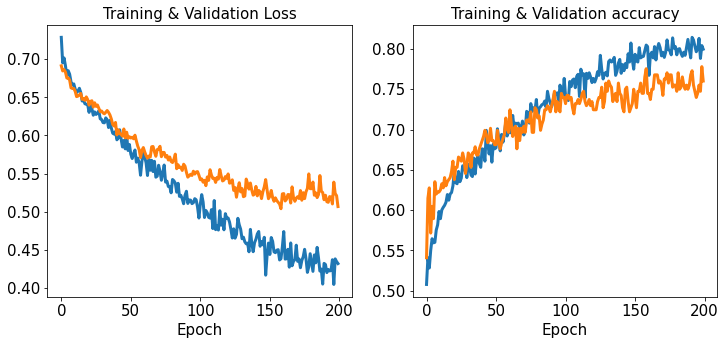

In [174]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [175]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [176]:
shap_values  = explainer.shap_values(np.array(X_test_new))

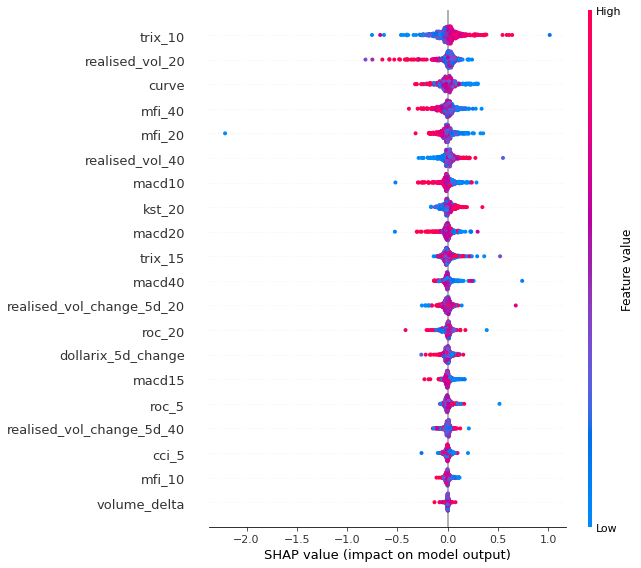

In [177]:
shap.summary_plot(shap_values[1], X_test_new)

In [178]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [179]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


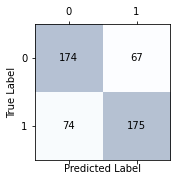

In [180]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [181]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.723
Recall: 0.703
F1: 0.713


In [182]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [183]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [184]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [20,30,40],
  }
]

In [185]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [186]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [187]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [188]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 25.9min finished


In [189]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/'+stock+'/xgb_'+stock+'_log_reg.pickle', "wb"))

In [190]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9365223601685704
Accuracy: 0.8653061224489796


Confusion Matrix


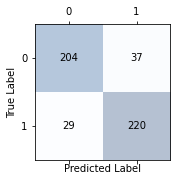

In [191]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [193]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7f9d435a61e0>}


In [201]:
k=40
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]




In [202]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.213265	validation_0-logloss:0.656487	validation_1-error:0.37551	validation_1-logloss:0.68071
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.131122	validation_0-logloss:0.625914	validation_1-error:0.389796	validation_1-logloss:0.674457
[2]	validation_0-error:0.108163	validation_0-logloss:0.600892	validation_1-error:0.412245	validation_1-logloss:0.666015
[3]	validation_0-error:0.068878	validation_0-logloss:0.561748	validation_1-error:0.332653	validation_1-logloss:0.64466
[4]	validation_0-error:0.047959	validation_0-logloss:0.536629	validation_1-error:0.318367	validation_1-logloss:0.63062
[5]	validation_0-error:0.045918	validation_0-logloss:0.522854	validation_1-error:0.297959	validation_1-logloss:0.625564
[6]	validation_0-error:0.042857	validation_0-logloss:0.510143	validation_1-error:0.304082	validation_1-logloss:0.62415


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [203]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.94%


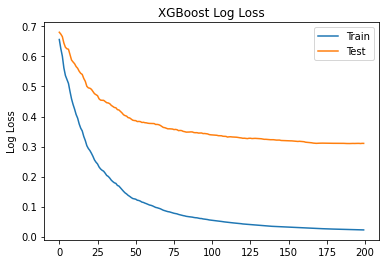

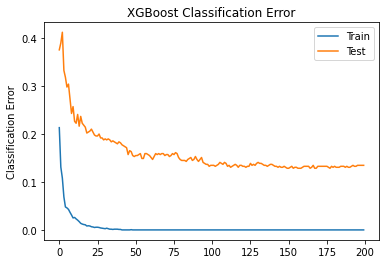

In [204]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [205]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


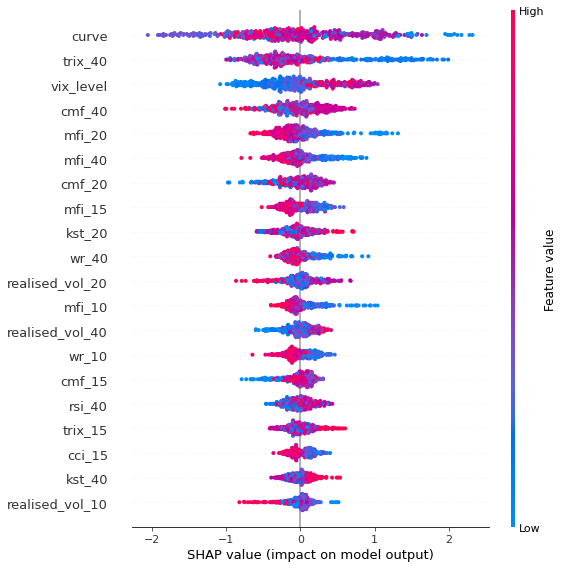

In [206]:
shap.summary_plot(shap_values, X_test_new)

In [207]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


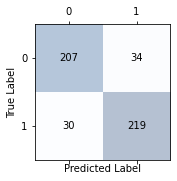

In [208]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()